<a href="https://colab.research.google.com/github/weathon/wild-fire/blob/main/WildFire_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Dataset Used
# https://www.kaggle.com/datasets/brsdincer/wildfire-detection-image-data

In [2]:
# !unzip archive.zip

In [3]:
!pip install torchinfo

In [4]:
import torch, torchinfo

class Block(torch.nn.Module):
  def __init__(self, i, o):
    super().__init__()
    self.conv1 = torch.nn.Conv2d(i, o, (3, 3), padding=1)
    self.pro1 = torch.nn.Conv2d(i, o, (1, 1))
    self.conv2 = torch.nn.Conv2d(o, o, (3, 3), 2)
    self.relu = torch.nn.ReLU()


  def forward(self, img):
    x = self.relu(self.conv1(img)) + self.pro1(img)
    return self.relu(self.conv2(x))

torchinfo.summary(Block(3, 16), (1,3,250,250))

Layer (type:depth-idx)                   Output Shape              Param #
Block                                    [1, 16, 124, 124]         --
├─Conv2d: 1-1                            [1, 16, 250, 250]         448
├─ReLU: 1-2                              [1, 16, 250, 250]         --
├─Conv2d: 1-3                            [1, 16, 250, 250]         64
├─Conv2d: 1-4                            [1, 16, 124, 124]         2,320
├─ReLU: 1-5                              [1, 16, 124, 124]         --
Total params: 2,832
Trainable params: 2,832
Non-trainable params: 0
Total mult-adds (M): 67.67
Input size (MB): 0.75
Forward/backward pass size (MB): 17.97
Params size (MB): 0.01
Estimated Total Size (MB): 18.73

In [5]:
class Model(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.block1 = Block(3, 16)
    self.block2 = Block(16, 32)
    self.block3 = Block(32, 64)
    self.block4 = Block(64, 128)
    self.block5 = Block(128, 256)
    self.f = torch.nn.Flatten()
    self.FC1 = torch.nn.Linear(9216, 1024)
    self.relu1 = torch.nn.ReLU()
    self.FC2 = torch.nn.Linear(1024, 16)
    self.relu2 = torch.nn.ReLU()
    self.FC3 = torch.nn.Linear(16, 1)

  def forward(self, x):
    x =  self.f(self.block5(self.block4(self.block3(self.block2(self.block1(x))))))
    return self.FC3(self.relu2(self.FC2(self.relu1(self.FC1(x)))))


torchinfo.summary(Model(), (1024,3,250,250))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [1024, 1]                 --
├─Block: 1-1                             [1024, 16, 124, 124]      --
│    └─Conv2d: 2-1                       [1024, 16, 250, 250]      448
│    └─ReLU: 2-2                         [1024, 16, 250, 250]      --
│    └─Conv2d: 2-3                       [1024, 16, 250, 250]      64
│    └─Conv2d: 2-4                       [1024, 16, 124, 124]      2,320
│    └─ReLU: 2-5                         [1024, 16, 124, 124]      --
├─Block: 1-2                             [1024, 32, 61, 61]        --
│    └─Conv2d: 2-6                       [1024, 32, 124, 124]      4,640
│    └─ReLU: 2-7                         [1024, 32, 124, 124]      --
│    └─Conv2d: 2-8                       [1024, 32, 124, 124]      544
│    └─Conv2d: 2-9                       [1024, 32, 61, 61]        9,248
│    └─ReLU: 2-10                        [1024, 32, 61, 61]        --
├─Bl

In [6]:
images = []
tags = []

import cv2, os
for i in os.listdir("/content/forest_fire/Training and Validation/fire"):
  # https://stackoverflow.com/questions/50963283/imshow-doesnt-need-convert-from-bgr-to-rgb
  images.append(cv2.cvtColor(cv2.imread("/content/forest_fire/Training and Validation/fire/"+i), cv2.COLOR_BGR2RGB))
  tags.append(1)

for i in os.listdir("/content/forest_fire/Training and Validation/nofire"):
  images.append(cv2.cvtColor(cv2.imread("/content/forest_fire/Training and Validation/nofire/"+i), cv2.COLOR_BGR2RGB))
  tags.append(0)

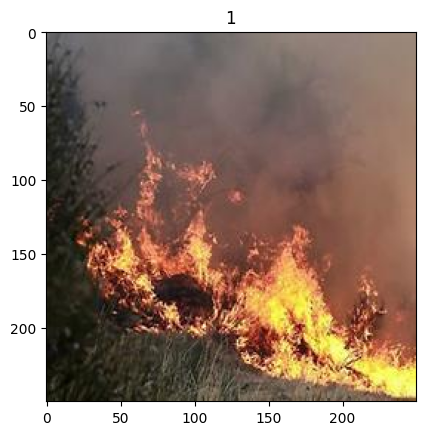

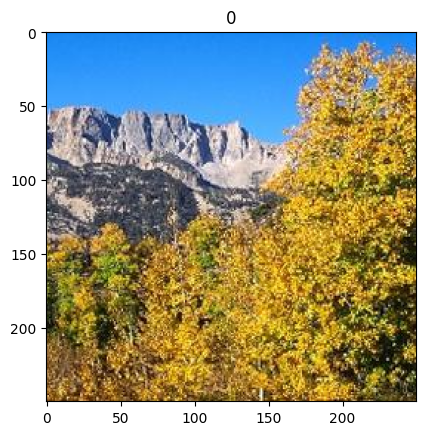

In [7]:
import pylab
pylab.imshow(images[0])
pylab.title(tags[0])
pylab.show()

pylab.imshow(images[-1])
pylab.title(tags[-1])
pylab.show()

In [8]:
import numpy as np

#shuffle
indexes = np.arange(len(images))
np.random.shuffle(indexes)
images = torch.tensor(np.array(images)[indexes], dtype=torch.float32).cuda()
tags = torch.tensor(np.array(tags)[indexes], dtype=torch.float32).cuda()

In [9]:
images.shape

torch.Size([1832, 250, 250, 3])

In [10]:
losses = []
acc = []

def sigmoid(x):
  # https://en.wikipedia.org/wiki/Sigmoid_function
  return 1/(1+torch.exp(-x))

try:
  del m
except:
  pass
m = Model().cuda()
adam  = torch.optim.Adam(m.parameters())


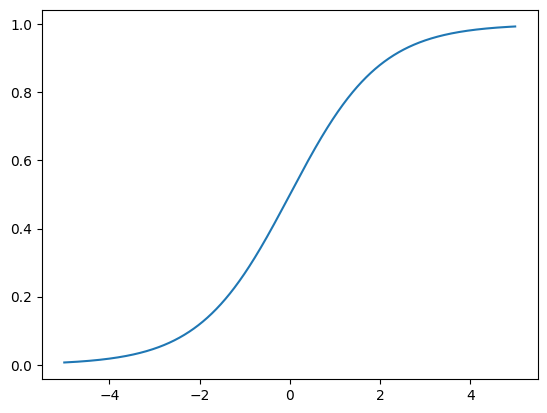

In [11]:
pylab.plot(torch.arange(-5,5,0.01), sigmoid(torch.arange(-5,5,0.01)))

In [15]:
loss = torch.nn.BCELoss()
acc_loss = 0.
for EPOCH in range(30):
  np.random.shuffle(indexes)
  images = torch.tensor(images[indexes], dtype=torch.float32).cuda()
  tags = torch.tensor(tags[indexes], dtype=torch.float32).cuda()
  for i in range(len(images)):
    adam.zero_grad()
    # https://stackoverflow.com/questions/65470807/how-to-add-a-new-dimension-to-a-pytorch-tensor
    predicted = sigmoid(m(
        torch.unsqueeze(torch.permute(images[i], (2, 0, 1)), 0)
        ))
    # predicted = sigmoid(m(torch.permute(images[i], (2, 0, 1)).unsqueeze(0)))
    # l = loss(predicted, torch.unsqueeze(torch.unsqueeze(torch.tensor(0.), 0), 0).cuda())
    # print(predicted)
    l = loss(predicted, torch.unsqueeze(torch.unsqueeze(tags[i], 0), 0).cuda())
    acc_loss += l
    # print(l) why it is 0 or 100
    l.backward()
    adam.step()
    losses.append(l)
    # adam.setp()
    acc.append(torch.round(predicted)==tags[i])
    if i%100==99:
      print(acc_loss/100)
      acc_loss = 0.

<ipython-input-15-2a0ddb5387d2>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images[indexes], dtype=torch.float32).cuda()
<ipython-input-15-2a0ddb5387d2>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tags = torch.tensor(tags[indexes], dtype=torch.float32).cuda()


tensor(0.6935, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6931, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6923, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6933, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6931, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6939, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6940, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6932, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6938, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6923, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6926, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6933, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6923, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6945, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6932, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6936, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6916, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6933, device='cuda:0', grad_fn=<DivBack

KeyboardInterrupt: ignored

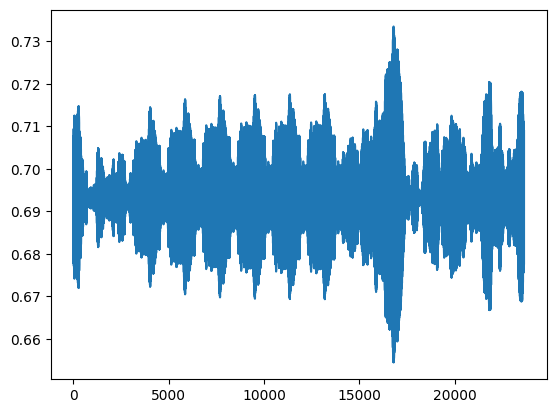

In [23]:
pylab.plot([i.detach().cpu().numpy() for i in losses][100:])